In [11]:
from __future__ import annotations

import hist
import argparse
import importlib
import logging
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import mplhep as hep

hep.style.use("CMS")

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc, roc_curve

import HH4b.utils as utils
from HH4b import hh_vars
from HH4b.log_utils import log_config
from HH4b.plotting import multiROCCurveGrey
from HH4b.utils import get_var_mapping

In [12]:
def load_events_and_bdt(path_to_dir, year, jet_coll_pnet, jet_coll_mass, bdt_models):
    # logger.info(f"Load {year}")

    jet_collection = "bbFatJet"
    reorder_txbb = True
    txbb_str = "bbFatJet" + jet_coll_pnet
    mass_str = "bbFatJet" + jet_coll_mass

    txbb_preselection = {
        "bbFatJetPNetTXbb": 0.3,
        "bbFatJetPNetTXbbLegacy": 0.8,
        "bbFatJetParTTXbb": 0.3,
    }
    msd1_preselection = {
        "bbFatJetPNetTXbb": 40,
        "bbFatJetPNetTXbbLegacy": 40,
        "bbFatJetParTTXbb": 40,
    }
    msd2_preselection = {
        "bbFatJetPNetTXbb": 30,
        "bbFatJetPNetTXbbLegacy": 0,
        "bbFatJetParTTXbb": 30,
    }

    sample_dirs = {
        year: {
            "QCD": [
                "QCD_HT-1000to1200",
                "QCD_HT-1200to1500",
                "QCD_HT-1500to2000",
                "QCD_HT-2000",
                "QCD_HT-400to600",
                "QCD_HT-600to800",
                "QCD_HT-800to1000",
            ],
            "ttbar": [
                "TTto4Q",
            ],
            "diboson": [
                "WW",
                "WZ",
                "ZZ",
            ],
            "VBFHH": [
                "VBFHHTo4B_CV_1_C2V_1_C3_1_TuneCP5_13TeV-madgraph-pythia8",
                "VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-1p74_C2V-1p37_C3-14p4_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m0p012_C2V-0p030_C3-10p2_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m0p758_C2V-1p44_C3-m19p3_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m0p962_C2V-0p959_C3-m1p43_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m1p21_C2V-1p94_C3-m0p94_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m1p60_C2V-2p72_C3-m1p36_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m1p83_C2V-3p57_C3-m3p39_TuneCP5_13p6TeV_madgraph-pythia8",
                "VBFHHto4B_CV-m2p12_C2V-3p87_C3-m5p96_TuneCP5_13p6TeV_madgraph-pythia8",
            ],
            "VBFH": [
                "VBFHto2B_M-125_dipoleRecoilOn",
            ],
        },
    }
    sample_dirs_sig = {
        year: {
            "hh4b": [
                "GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV?"
            ],  # the ? enforces exact matching
        }
    }

    num_jets = 2

    columns = [
        ("weight", 1),  # genweight * otherweights
        ("event", 1),
        ("MET_pt", 1),
        ("bbFatJetTau3OverTau2", 2),
        ("VBFJetPt", 2),
        ("VBFJetEta", 2),
        ("VBFJetPhi", 2),
        ("VBFJetMass", 2),
        ("AK4JetAwayPt", 2),
        ("AK4JetAwayEta", 2),
        ("AK4JetAwayPhi", 2),
        ("AK4JetAwayMass", 2),
        (f"{jet_collection}Pt", num_jets),
        (f"{jet_collection}Msd", num_jets),
        (f"{jet_collection}Eta", num_jets),
        (f"{jet_collection}Phi", num_jets),
        (f"{jet_collection}PNetPXbbLegacy", num_jets),  # Legacy PNet
        (f"{jet_collection}PNetPQCDbLegacy", num_jets),
        (f"{jet_collection}PNetPQCDbbLegacy", num_jets),
        (f"{jet_collection}PNetPQCD0HFLegacy", num_jets),
        (f"{jet_collection}PNetMassLegacy", num_jets),
        (f"{jet_collection}PNetTXbbLegacy", num_jets),
        (f"{jet_collection}PNetTXbb", num_jets),  # 103X PNet
        (f"{jet_collection}PNetMass", num_jets),
        (f"{jet_collection}PNetQCD0HF", num_jets),
        (f"{jet_collection}PNetQCD1HF", num_jets),
        (f"{jet_collection}PNetQCD2HF", num_jets),
        (f"{jet_collection}ParTmassVis", num_jets),  # GloParT
        (f"{jet_collection}ParTTXbb", num_jets),
        (f"{jet_collection}ParTPXbb", num_jets),
        (f"{jet_collection}ParTPQCD0HF", num_jets),
        (f"{jet_collection}ParTPQCD1HF", num_jets),
        (f"{jet_collection}ParTPQCD2HF", num_jets),
    ]
    signal_exclusive_columns = []

    # selection to apply
    filters = [
        [
            (f"('{jet_collection}Pt', '0')", ">=", 250),
            (f"('{jet_collection}Pt', '1')", ">=", 250),
        ],
    ]

    def apply_cuts(events_dict, txbb_str, mass_str):
        for key in events_dict:

            msd1 = events_dict[key]["bbFatJetMsd"][0]
            msd2 = events_dict[key]["bbFatJetMsd"][1]
            pt1 = events_dict[key]["bbFatJetPt"][0]
            pt2 = events_dict[key]["bbFatJetPt"][1]
            txbb1 = events_dict[key][txbb_str][0]
            mass1 = events_dict[key][mass_str][0]
            mass2 = events_dict[key][mass_str][1]
            # add msd > 40 cut for the first jet FIXME: replace this by the trigobj matched jet
            events_dict[key] = events_dict[key][
                (pt1 > 250)
                & (pt2 > 250)
                & (txbb1 > txbb_preselection[txbb_str])
                & (msd1 > msd1_preselection[txbb_str])
                & (msd2 > msd2_preselection[txbb_str])
                & (mass1 > 50)
                & (mass2 > 50)
            ].copy()

        return events_dict

    # dictionary that will contain all information (from all samples)
    events_dict = {
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            path_to_dir,
            sample_dirs_sig[year],
            year,
            filters=filters,
            columns=utils.format_columns(columns + signal_exclusive_columns),
            reorder_txbb=reorder_txbb,
            txbb_str=txbb_str,
            variations=False,
        ),
        **utils.load_samples(
            path_to_dir,  # input directory
            sample_dirs[year],
            year,  # year (to find corresponding luminosity)
            filters=filters,
            columns=utils.format_columns(
                columns
            ),  # columns to load from parquet (to not load all columns), IMPORTANT columns must be formatted: ("column name", "idx")
            reorder_txbb=reorder_txbb,  # whether to reorder bbFatJet collection
            txbb_str=txbb_str,
            variations=False,  # do not load systematic variations of weights
        ),
    }

    def get_bdt(events_dict, bdt_model, bdt_model_name, bdt_config, jlabel=""):
        bdt_model = xgb.XGBClassifier()
        bdt_model.load_model(
            fname=f"../boosted/bdt_trainings_run3/{bdt_model_name}/trained_bdt.model"
        )
        make_bdt_dataframe = importlib.import_module(
            f".{bdt_config}", package="HH4b.boosted.bdt_trainings_run3"
        )
        bdt_events = make_bdt_dataframe.bdt_dataframe(events_dict, get_var_mapping(jlabel))
        preds = bdt_model.predict_proba(bdt_events)

        bdt_score = None
        bdt_score_vbf = None
        if preds.shape[1] == 2:  # binary BDT only
            bdt_score = preds[:, 1]
        elif preds.shape[1] == 3:  # multi-class BDT with ggF HH, QCD, ttbar classes
            bdt_score = preds[:, 0]  # ggF HH
        elif preds.shape[1] == 4:  # multi-class BDT with ggF HH, VBF HH, QCD, ttbar classes
            bg_tot = np.sum(preds[:, 2:], axis=1)
            bdt_score = preds[:, 0] / (preds[:, 0] + bg_tot)
            bdt_score_vbf = preds[:, 1] / (preds[:, 1] + preds[:, 2] + preds[:, 3])

        print(len(bdt_score))
        print(len(bdt_score_vbf))
        print(bdt_events.shape[0])
        return bdt_score, bdt_score_vbf, bdt_events

    events_dict = apply_cuts(events_dict, txbb_str, mass_str)

    # TODO: check that weights are applied and correct scores used
    bdt_score_dict = {}
    bdt_score_vbf_dict = {}
    bdt_df_dict = {}

    for bdt_model in bdt_models:
        # logger.info(f"Perform inference {bdt_model}")
        bdt_config = bdt_models[bdt_model]["config"]
        bdt_model_name = bdt_models[bdt_model]["model_name"]

        for key in events_dict:
            bdt_score, bdt_score_vbf, bdt_df = get_bdt(
                events_dict[key], bdt_model, bdt_model_name, bdt_config
            )

            # Add BDT scores back to the event dictionary under the specific key
            events_dict[key][f"bdtscore_{bdt_model}"] = (
                bdt_score if bdt_score is not None else np.ones(events_dict[key]["weight"])
            )
            events_dict[key][f"bdtscoreVBF_{bdt_model}"] = (
                bdt_score_vbf if bdt_score_vbf is not None else np.ones(events_dict[key]["weight"])
            )

            # Store the results for each key (hh4b, qcd, ttbar) separately
            if key not in bdt_score_dict:
                bdt_score_dict[key] = []
                bdt_score_vbf_dict[key] = []
                bdt_df_dict[key] = []

            # Append the BDT scores and DataFrame for each key
            bdt_score_dict[key].append(bdt_score)
            bdt_score_vbf_dict[key].append(bdt_score_vbf)
            bdt_df_dict[key].append(bdt_df)

    # Concatenate all the BDT scores and DataFrames for each key separately
    bdt_score_dict = {key: np.concatenate(bdt_score_dict[key]) for key in bdt_score_dict}
    bdt_score_vbf_dict = {
        key: np.concatenate(bdt_score_vbf_dict[key]) for key in bdt_score_vbf_dict
    }
    bdt_df_dict = {key: pd.concat(bdt_df_dict[key], ignore_index=True) for key in bdt_df_dict}

    # Add finalWeight to the list of columns being retained
    for key in events_dict:
        bdt_scores = [f"bdtscore_{bdt_model}", f"bdtscoreVBF_{bdt_model}", "finalWeight"]
        events_dict[key] = events_dict[key][bdt_scores]

    # Return dictionaries for BDT scores and the DataFrames, with keys retained
    return (
        bdt_score_dict,
        bdt_score_vbf_dict,
        bdt_df_dict,
    )  # TODO: adjust return values so they have keys for each sample key

In [13]:
"""
Plot BDT Inputs

#TODO: add description of the function

"""


def plot_bdt_features(bdt_score_dict, bdt_score_vbf_dict, bdt_df_dict, model_key):

    # Define the BDT cut thresholds
    bdt_cuts = [0.03, 0.88, 0.98]

    # Define colors and labels for each histogram, including before any cut
    colors = ["black", "blue", "green", "red"]  # Adjust colors as needed
    labels = ["Before BDT Cut", "BDT Cut > 0.03", "BDT Cut > 0.88", "BDT Cut > 0.98"]

    # Iterate over each key (e.g., "hh4b", "qcd", "ttbar")
    for key in bdt_score_dict:
        # Get BDT score, BDT score VBF, and BDT DataFrame for the current key
        bdt_score = bdt_score_dict[key]
        bdt_score_vbf = bdt_score_vbf_dict[key]
        bdt_df = bdt_df_dict[key]

        # Create boolean masks for each BDT cut
        bdt_masks = [np.ones(len(bdt_score), dtype=bool)]  # Initial mask: all True (no cut)
        for cut in bdt_cuts:
            bdt_masks.append(bdt_score > cut)

        bdt_masks_vbf = [np.ones(len(bdt_score_vbf), dtype=bool)]  # Initial mask: all True (no cut)
        for cut in bdt_cuts:
            bdt_masks_vbf.append(bdt_score_vbf > cut)

        # Filter the columns to exclude those containing "VBF" or "AK4"
        # columns_to_plot = [col for col in bdt_df.columns if ("VBF" not in col and "AK4" not in col)]

        columns_to_plot = ["H1Mass"]
        # print(columns_to_plot)
        # Loop over each feature in the DataFrame
        for column in columns_to_plot:
            plt.figure(figsize=(12, 6))
            print(f"Plotting {column} for {key}")

            # Define a consistent binning for the histogram (50 bins between min and max of the column)
            min_val = bdt_df[column].min()
            max_val = bdt_df[column].max()
            feature_axis = hist.axis.Regular(50, min_val, max_val, name="Feature", label=column)
            cut_axis = hist.axis.StrCategory([], name="Cut", growth=True)

            # Create a 2D histogram object for this feature and cuts
            h = hist.Hist(feature_axis, cut_axis)

            # Fill the histogram for each mask (i.e., each BDT cut)
            for i, mask in enumerate(bdt_masks):
                h.fill(Feature=bdt_df.loc[mask, column], Cut=labels[i])

            # Plot the histograms using mplhep
            hep.histplot(
                [h[{"Cut": label}] for label in labels],
                stack=False,
                density=True,
                histtype="step",
                label=labels,
                color=colors,
                linewidth=1.5,
            )

            plt.title(f"Distribution of {column} for {key} (model: {model_key})")
            plt.xlabel(f"{column} (GeV)")  # TODO: automate units
            plt.ylabel("Events (Normalized)")
            plt.legend()
            plt.grid(True)
            plt.show()

dict_items([('v5_ParT', {'config': 'v5_glopartv2', 'model_name': '24Sep27_v5_glopartv2'})])
43133
43133
43133
642173
642173
642173
816277
816277
816277
4335
4335
4335
112186
112186
112186
894
894
894
Plotting H1Mass for hh4b


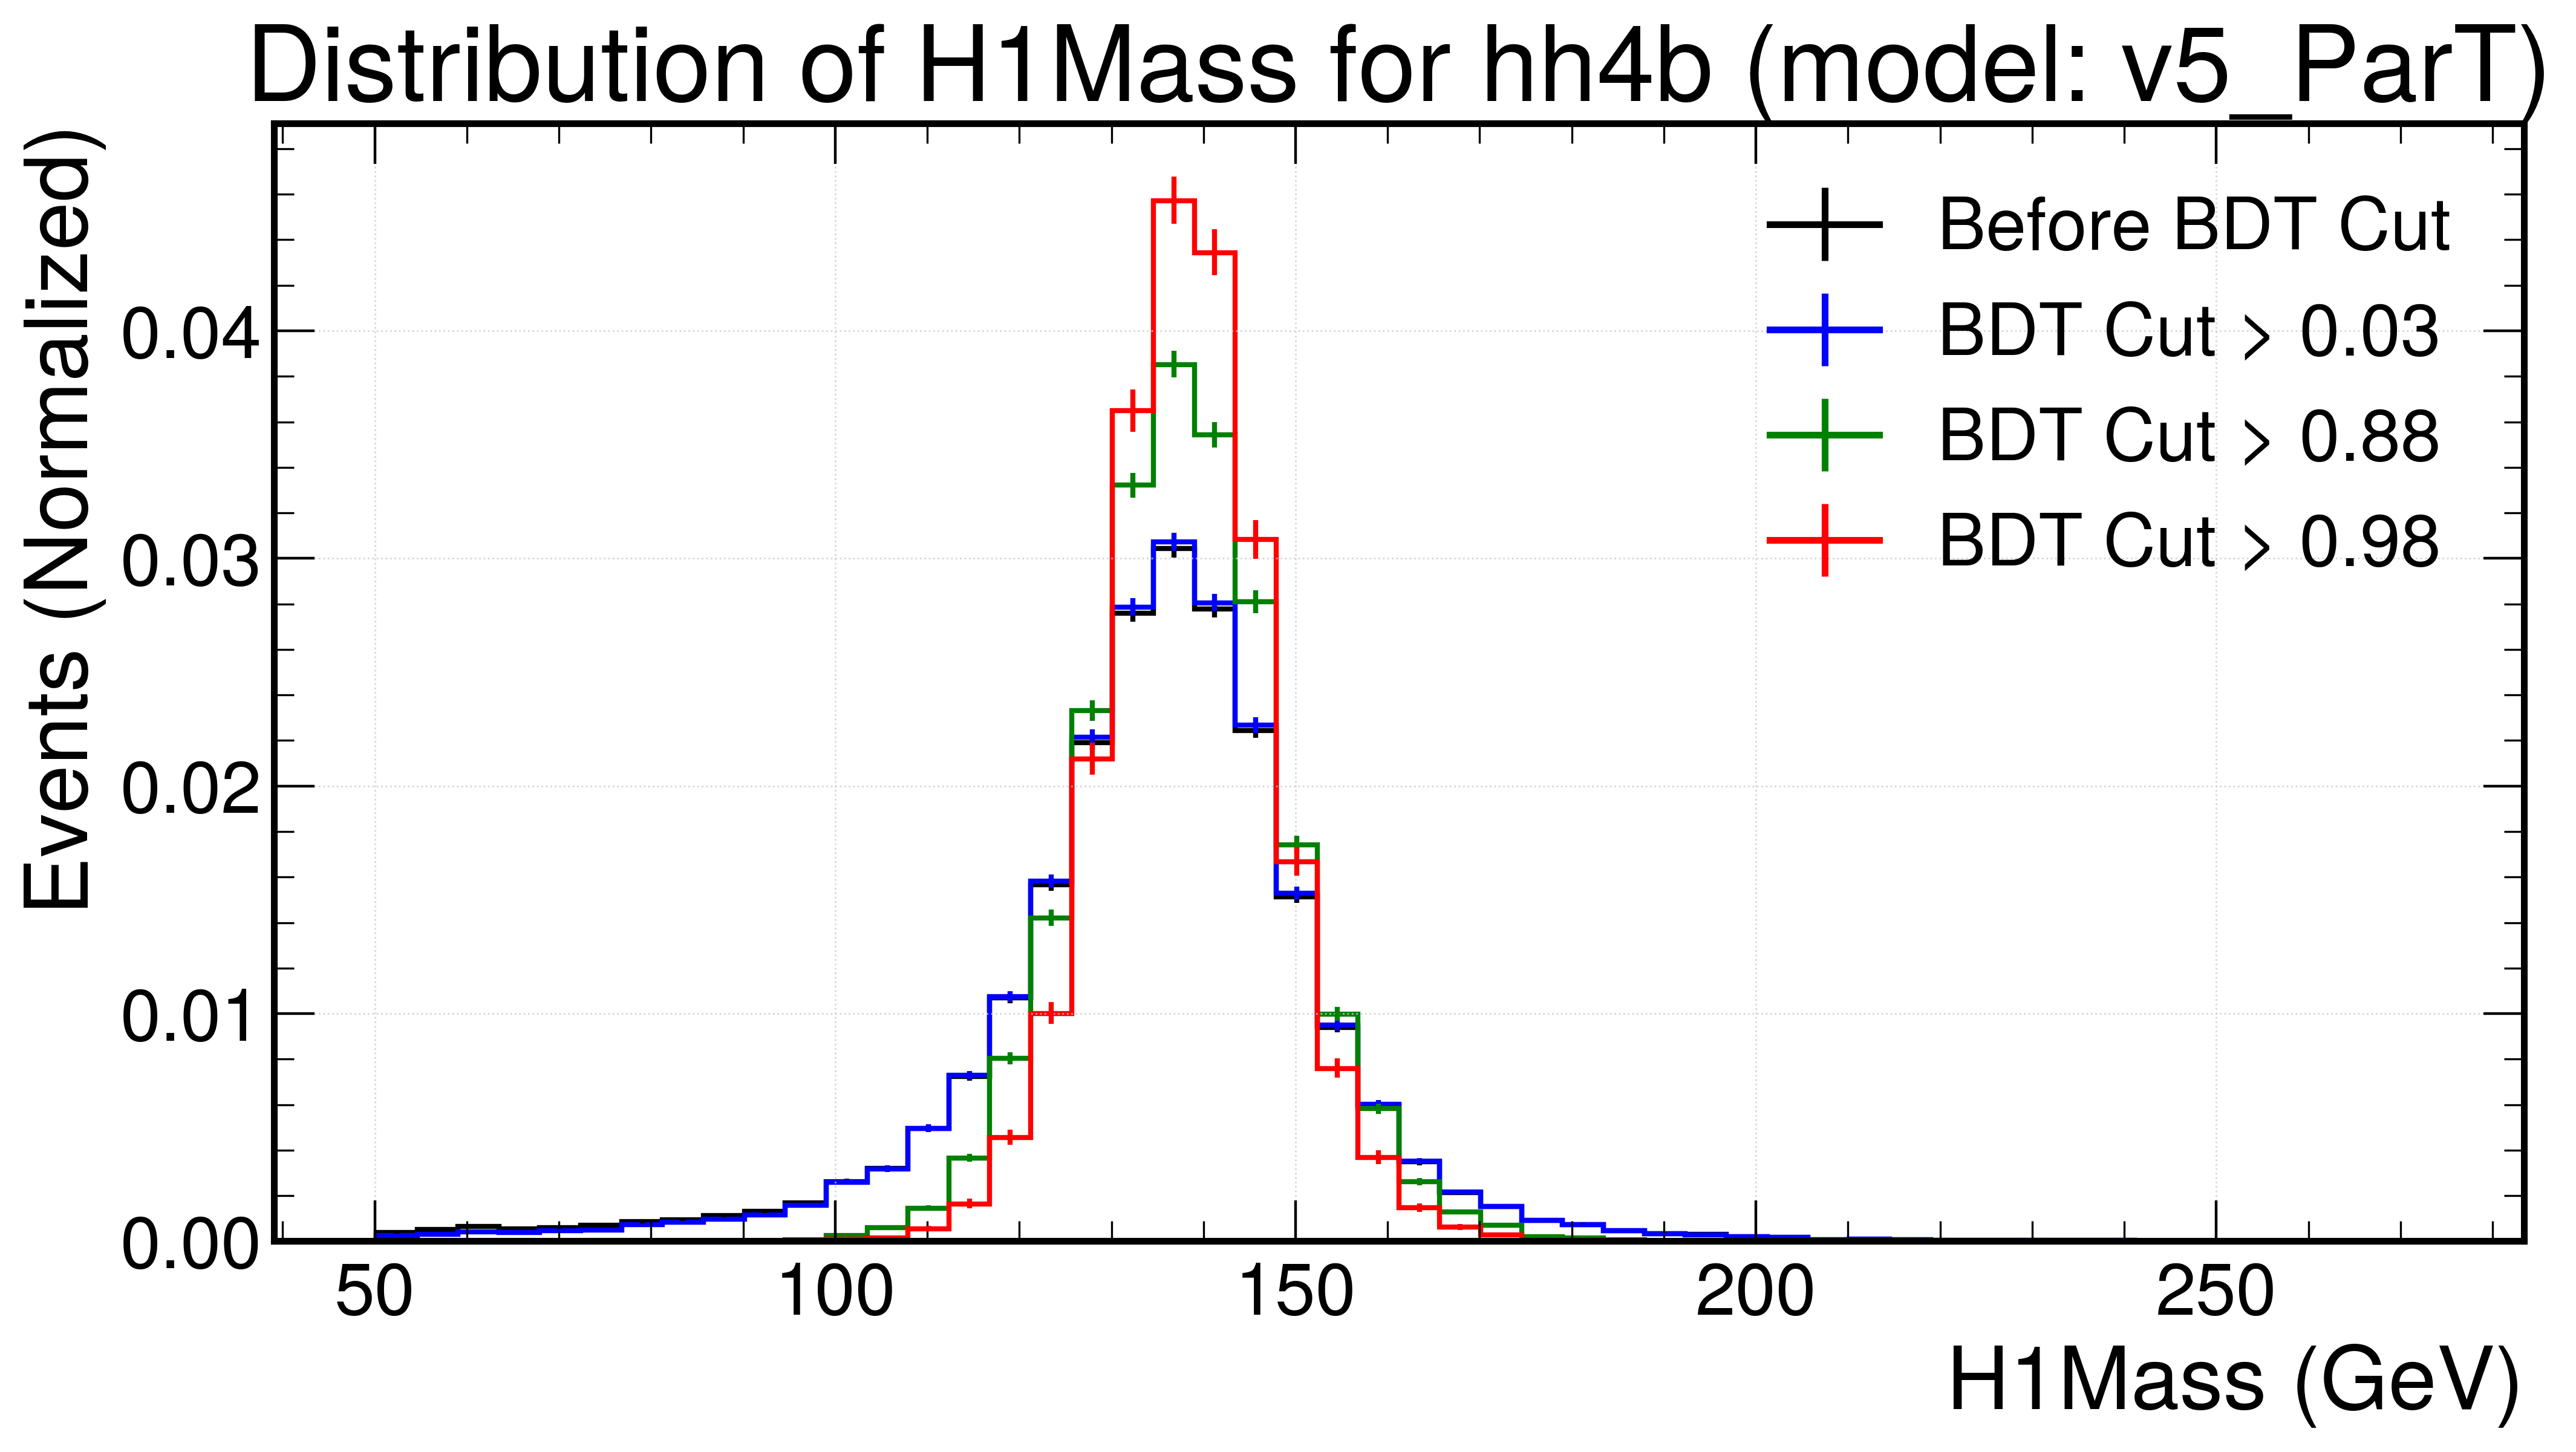

Plotting H1Mass for QCD


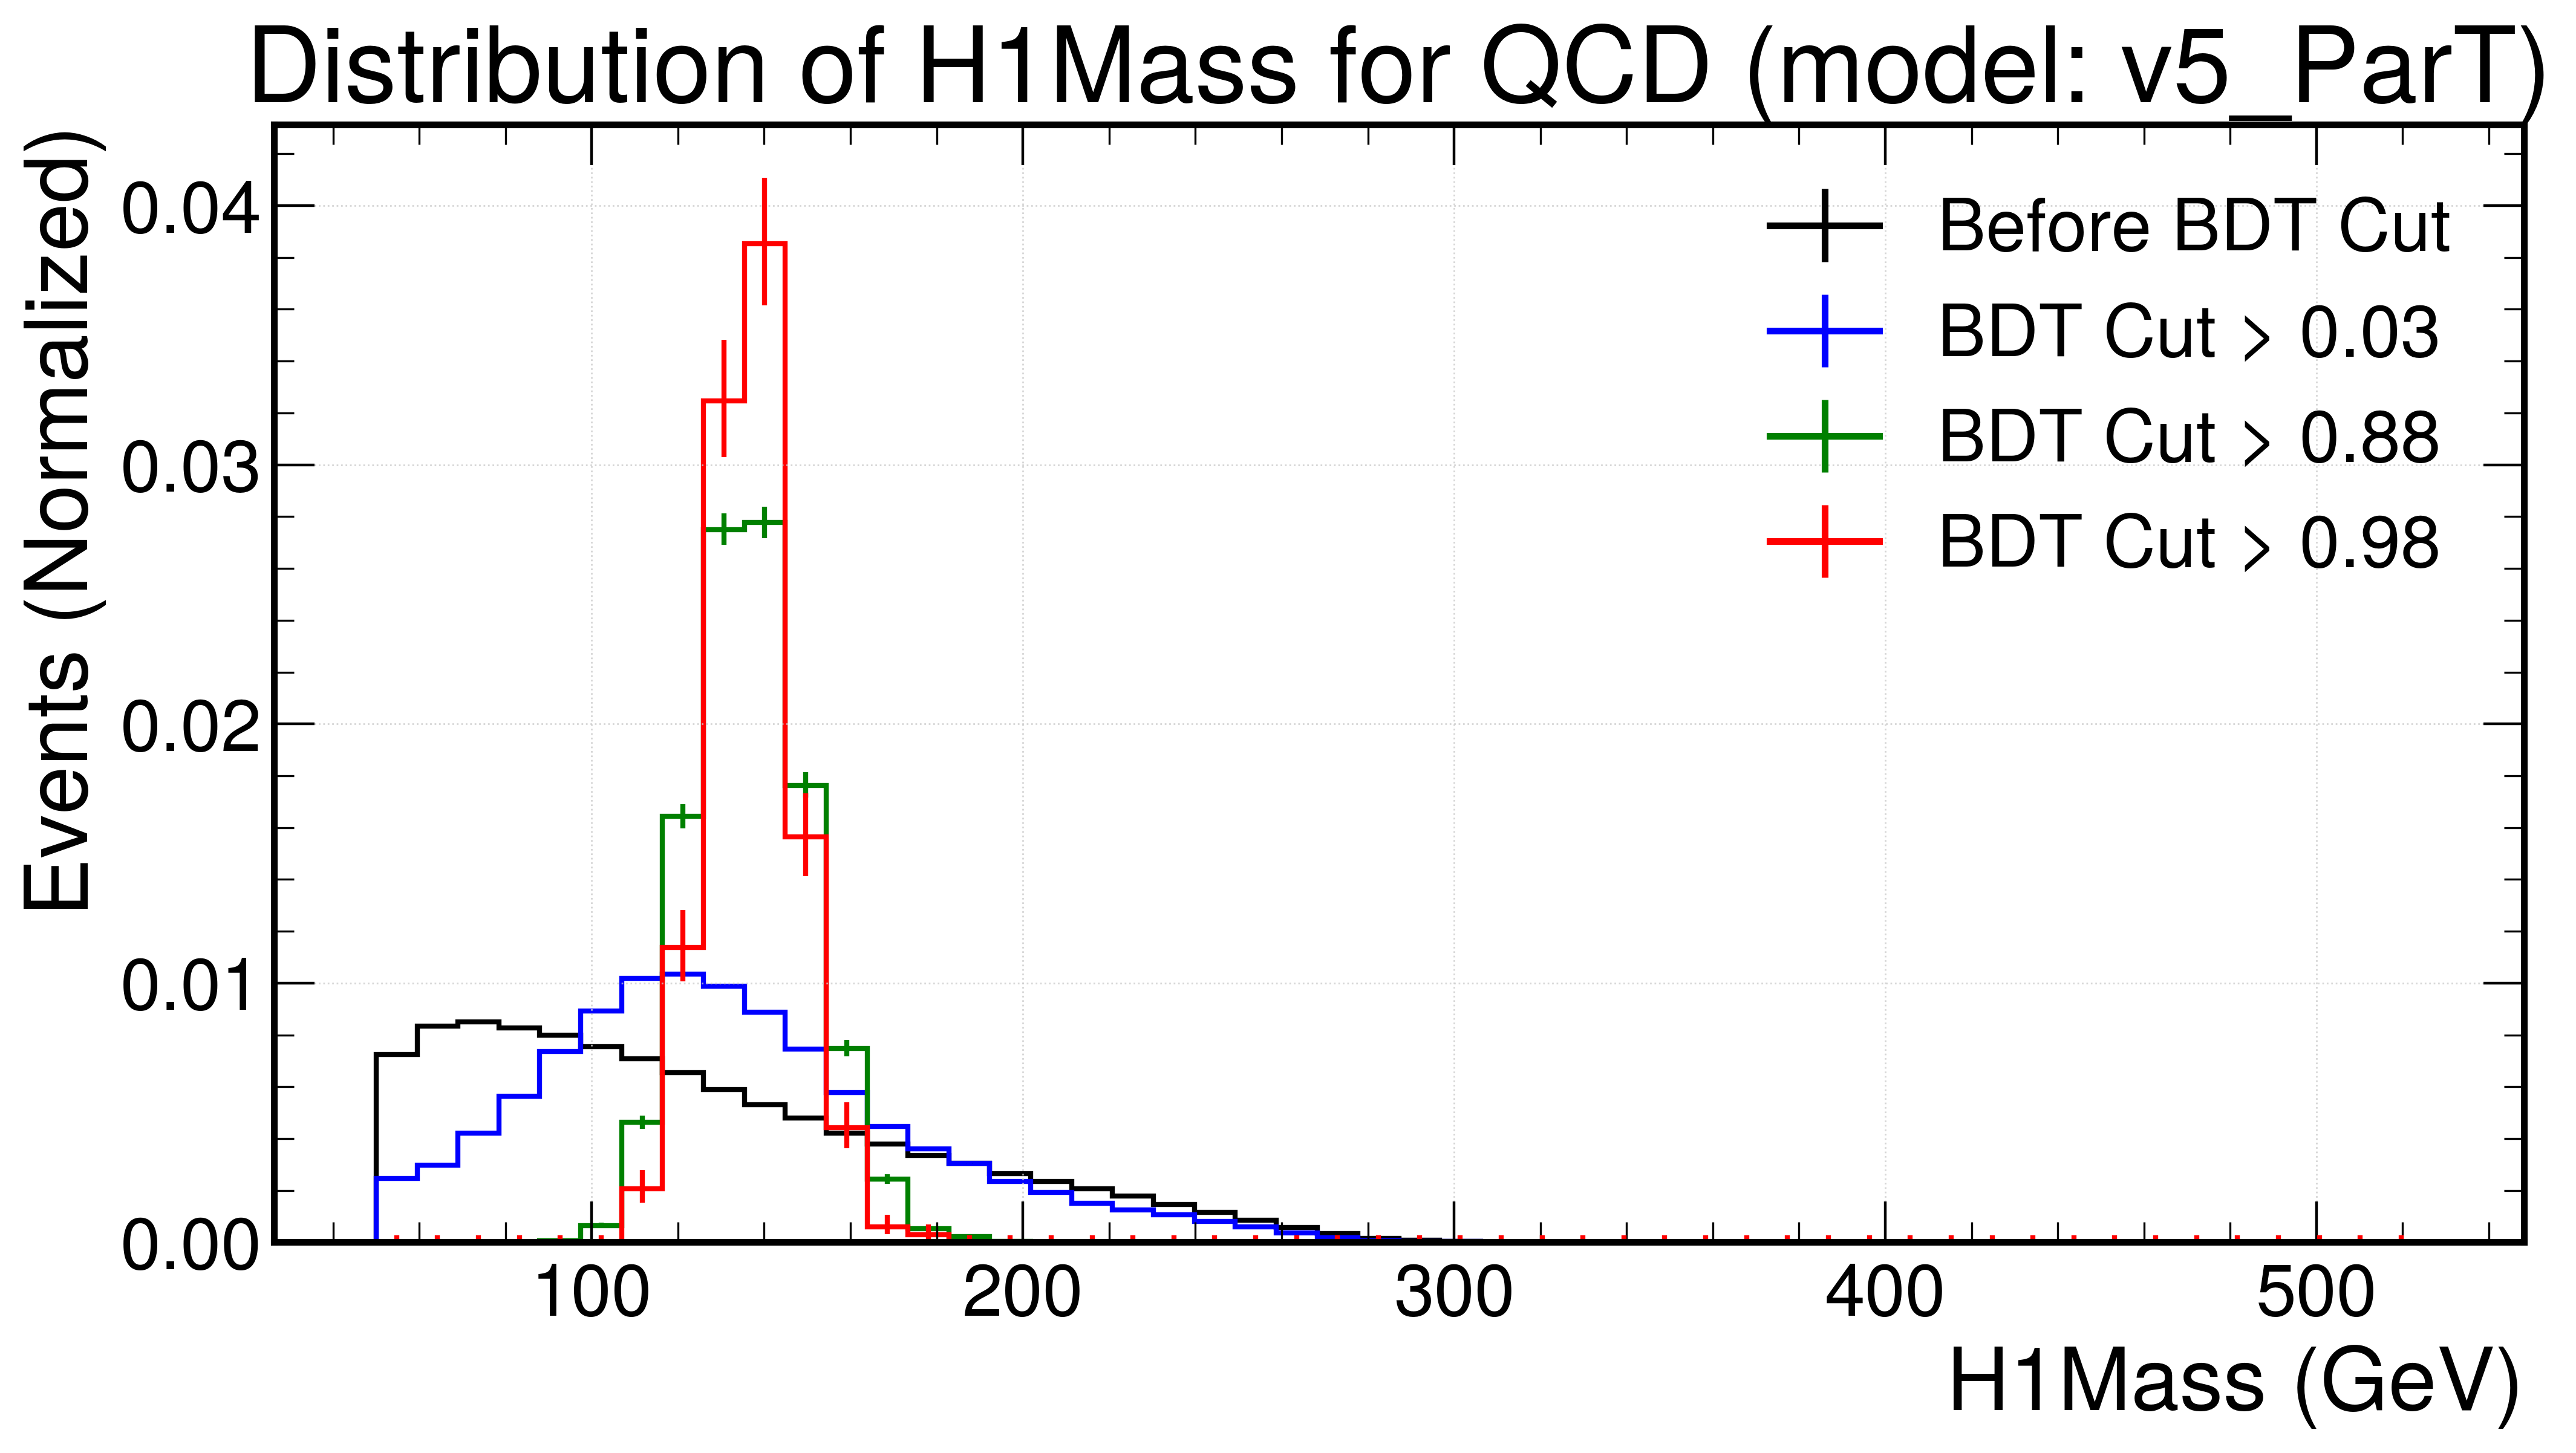

Plotting H1Mass for ttbar


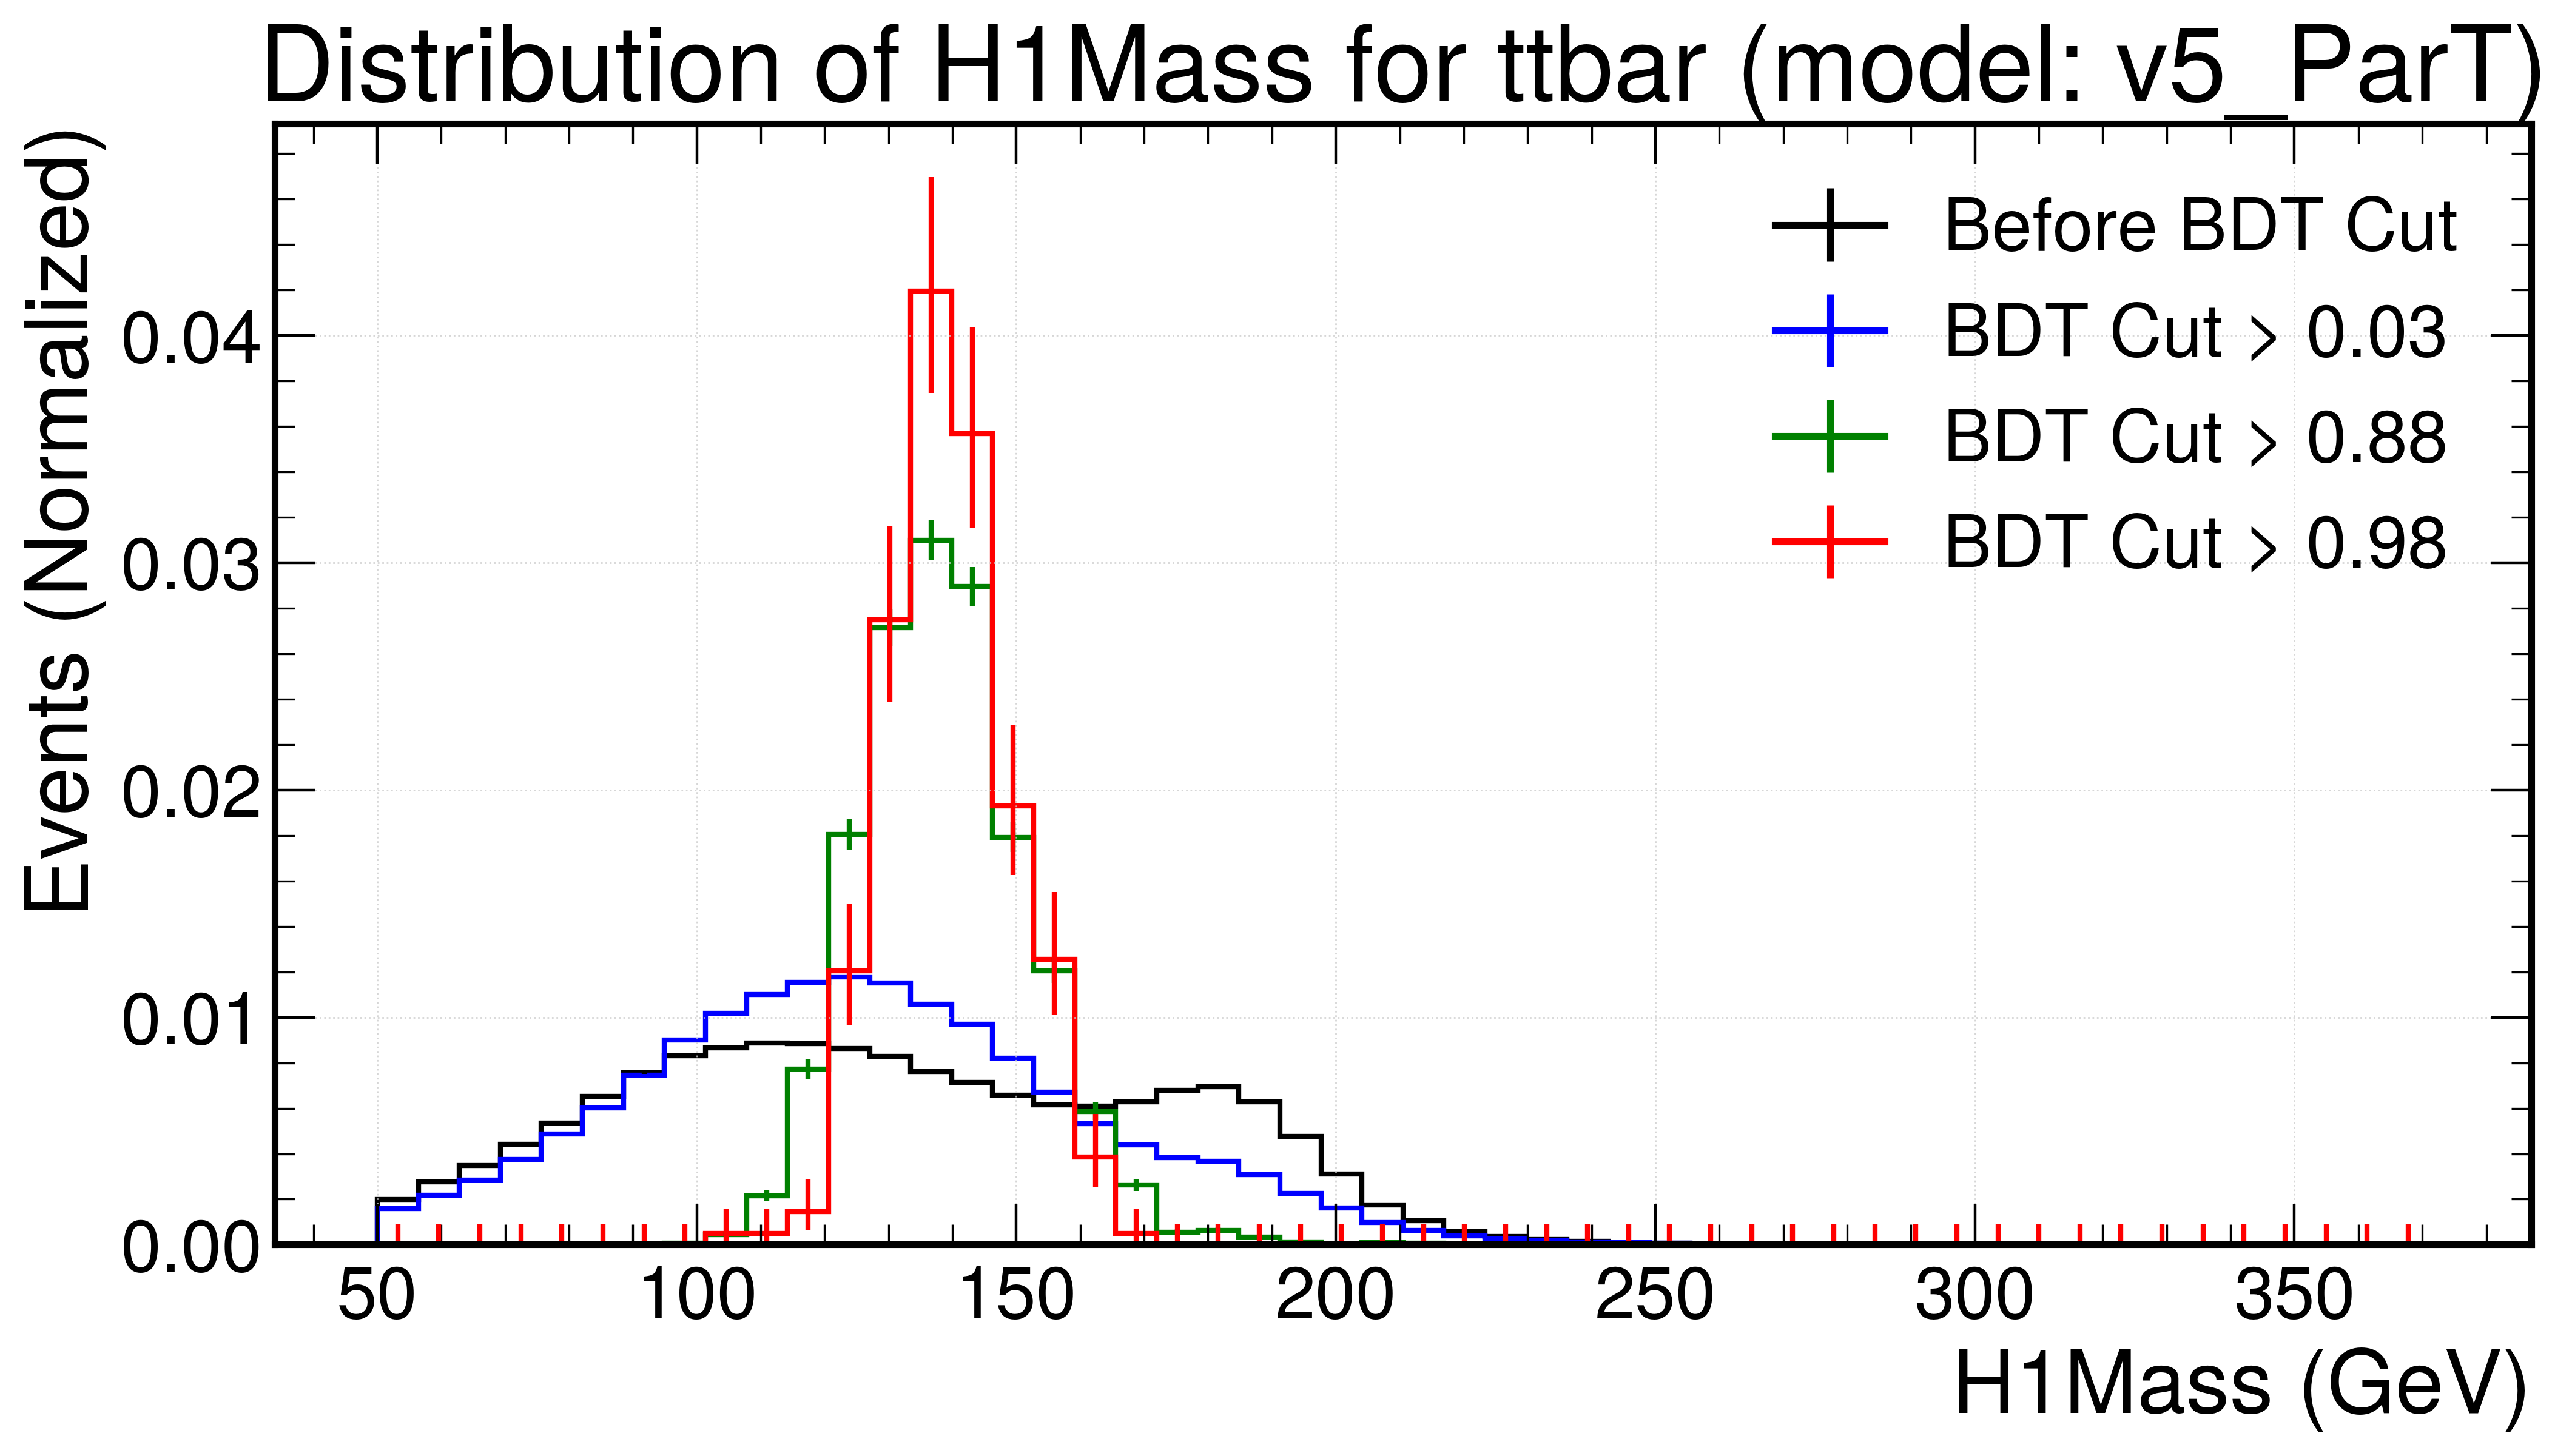

Plotting H1Mass for diboson


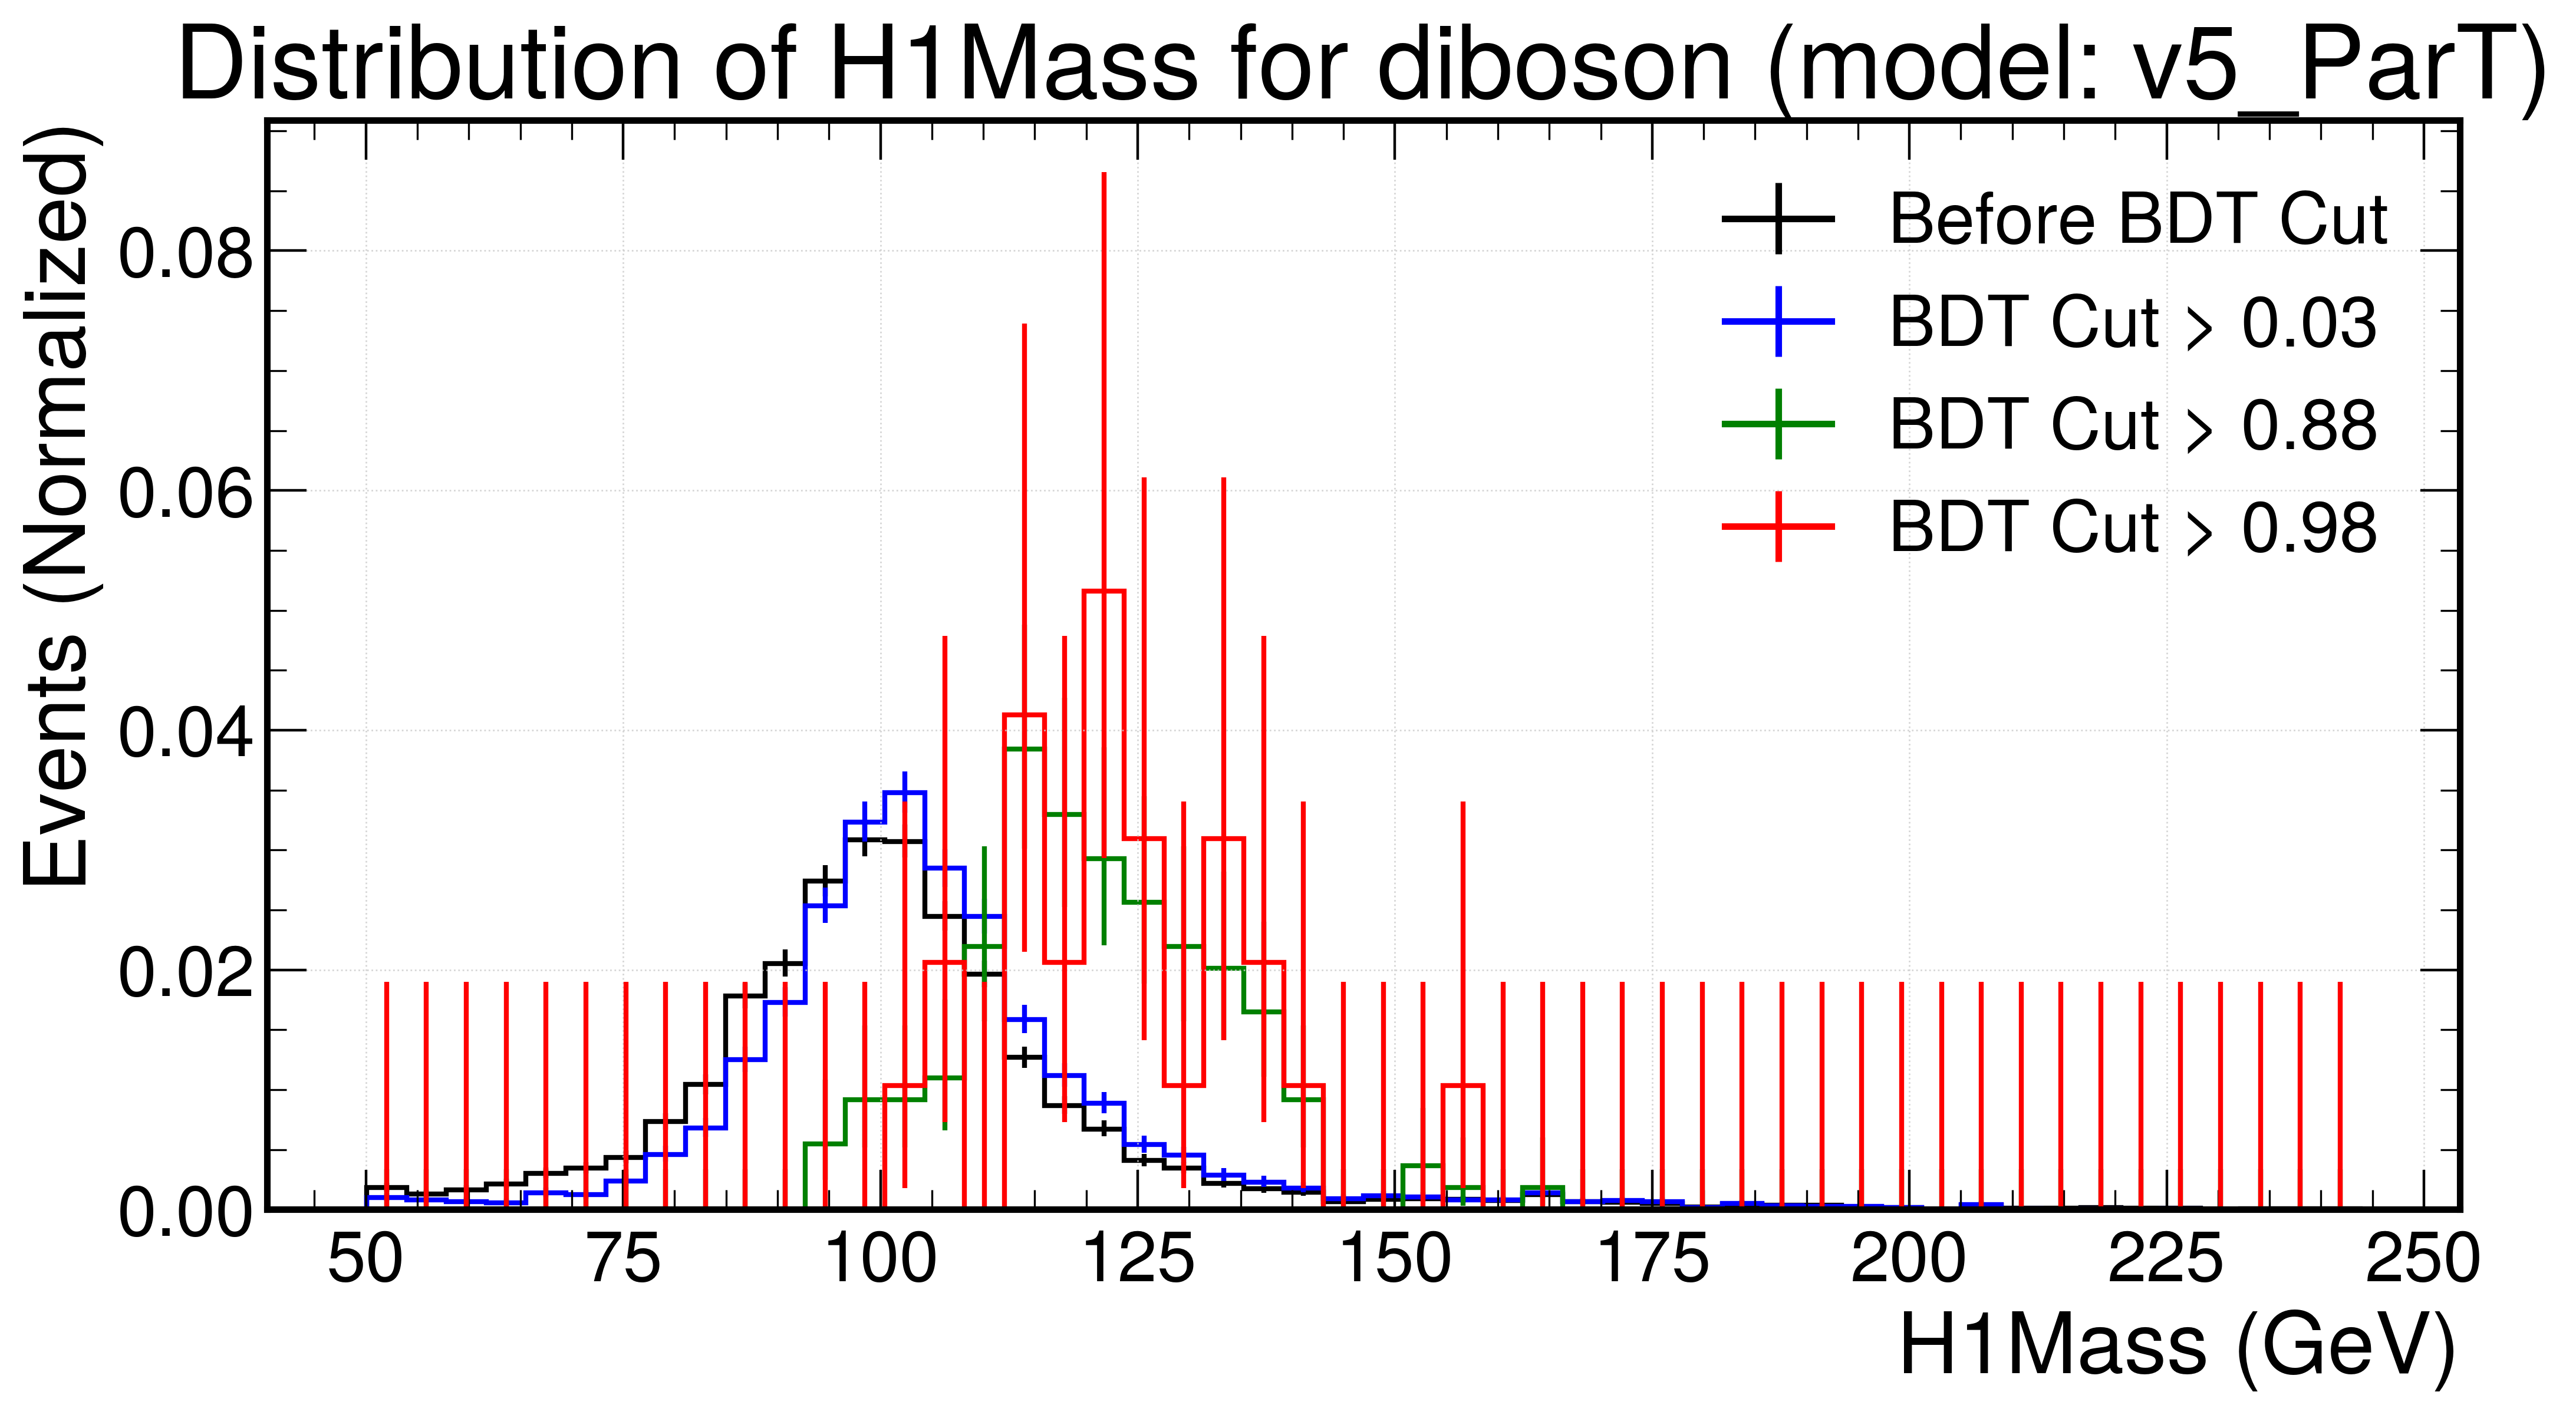

Plotting H1Mass for VBFHH


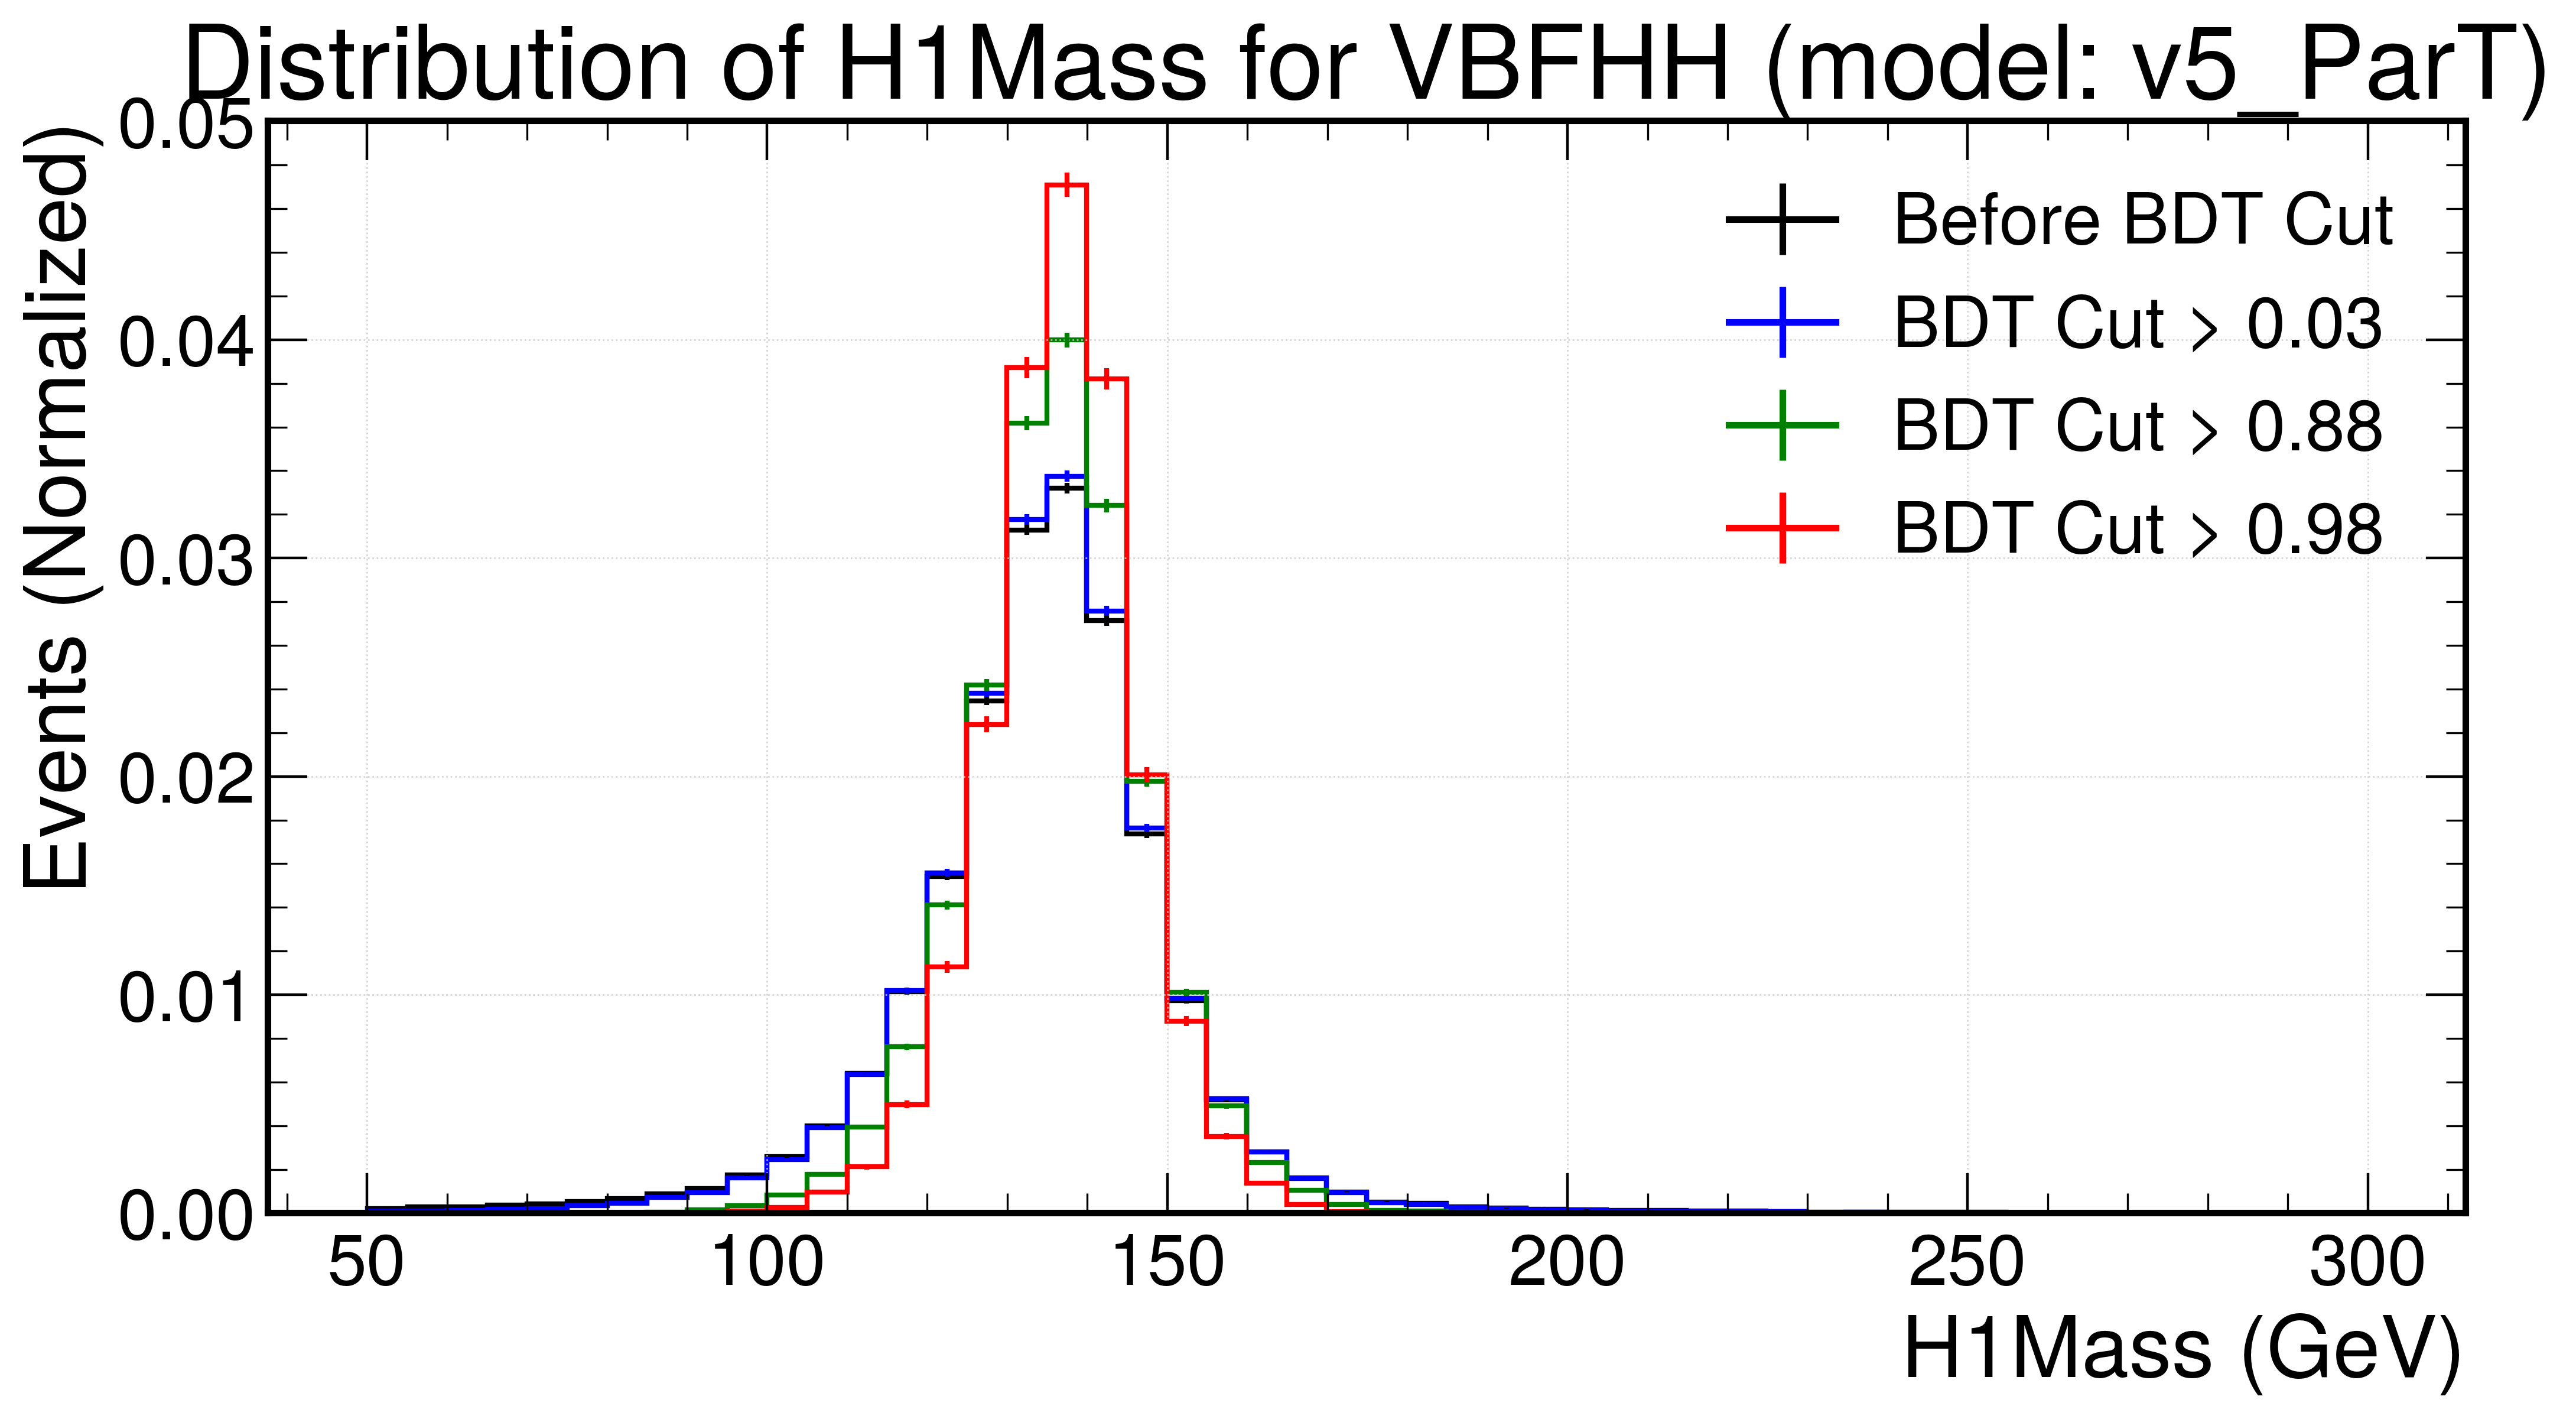

Plotting H1Mass for VBFH


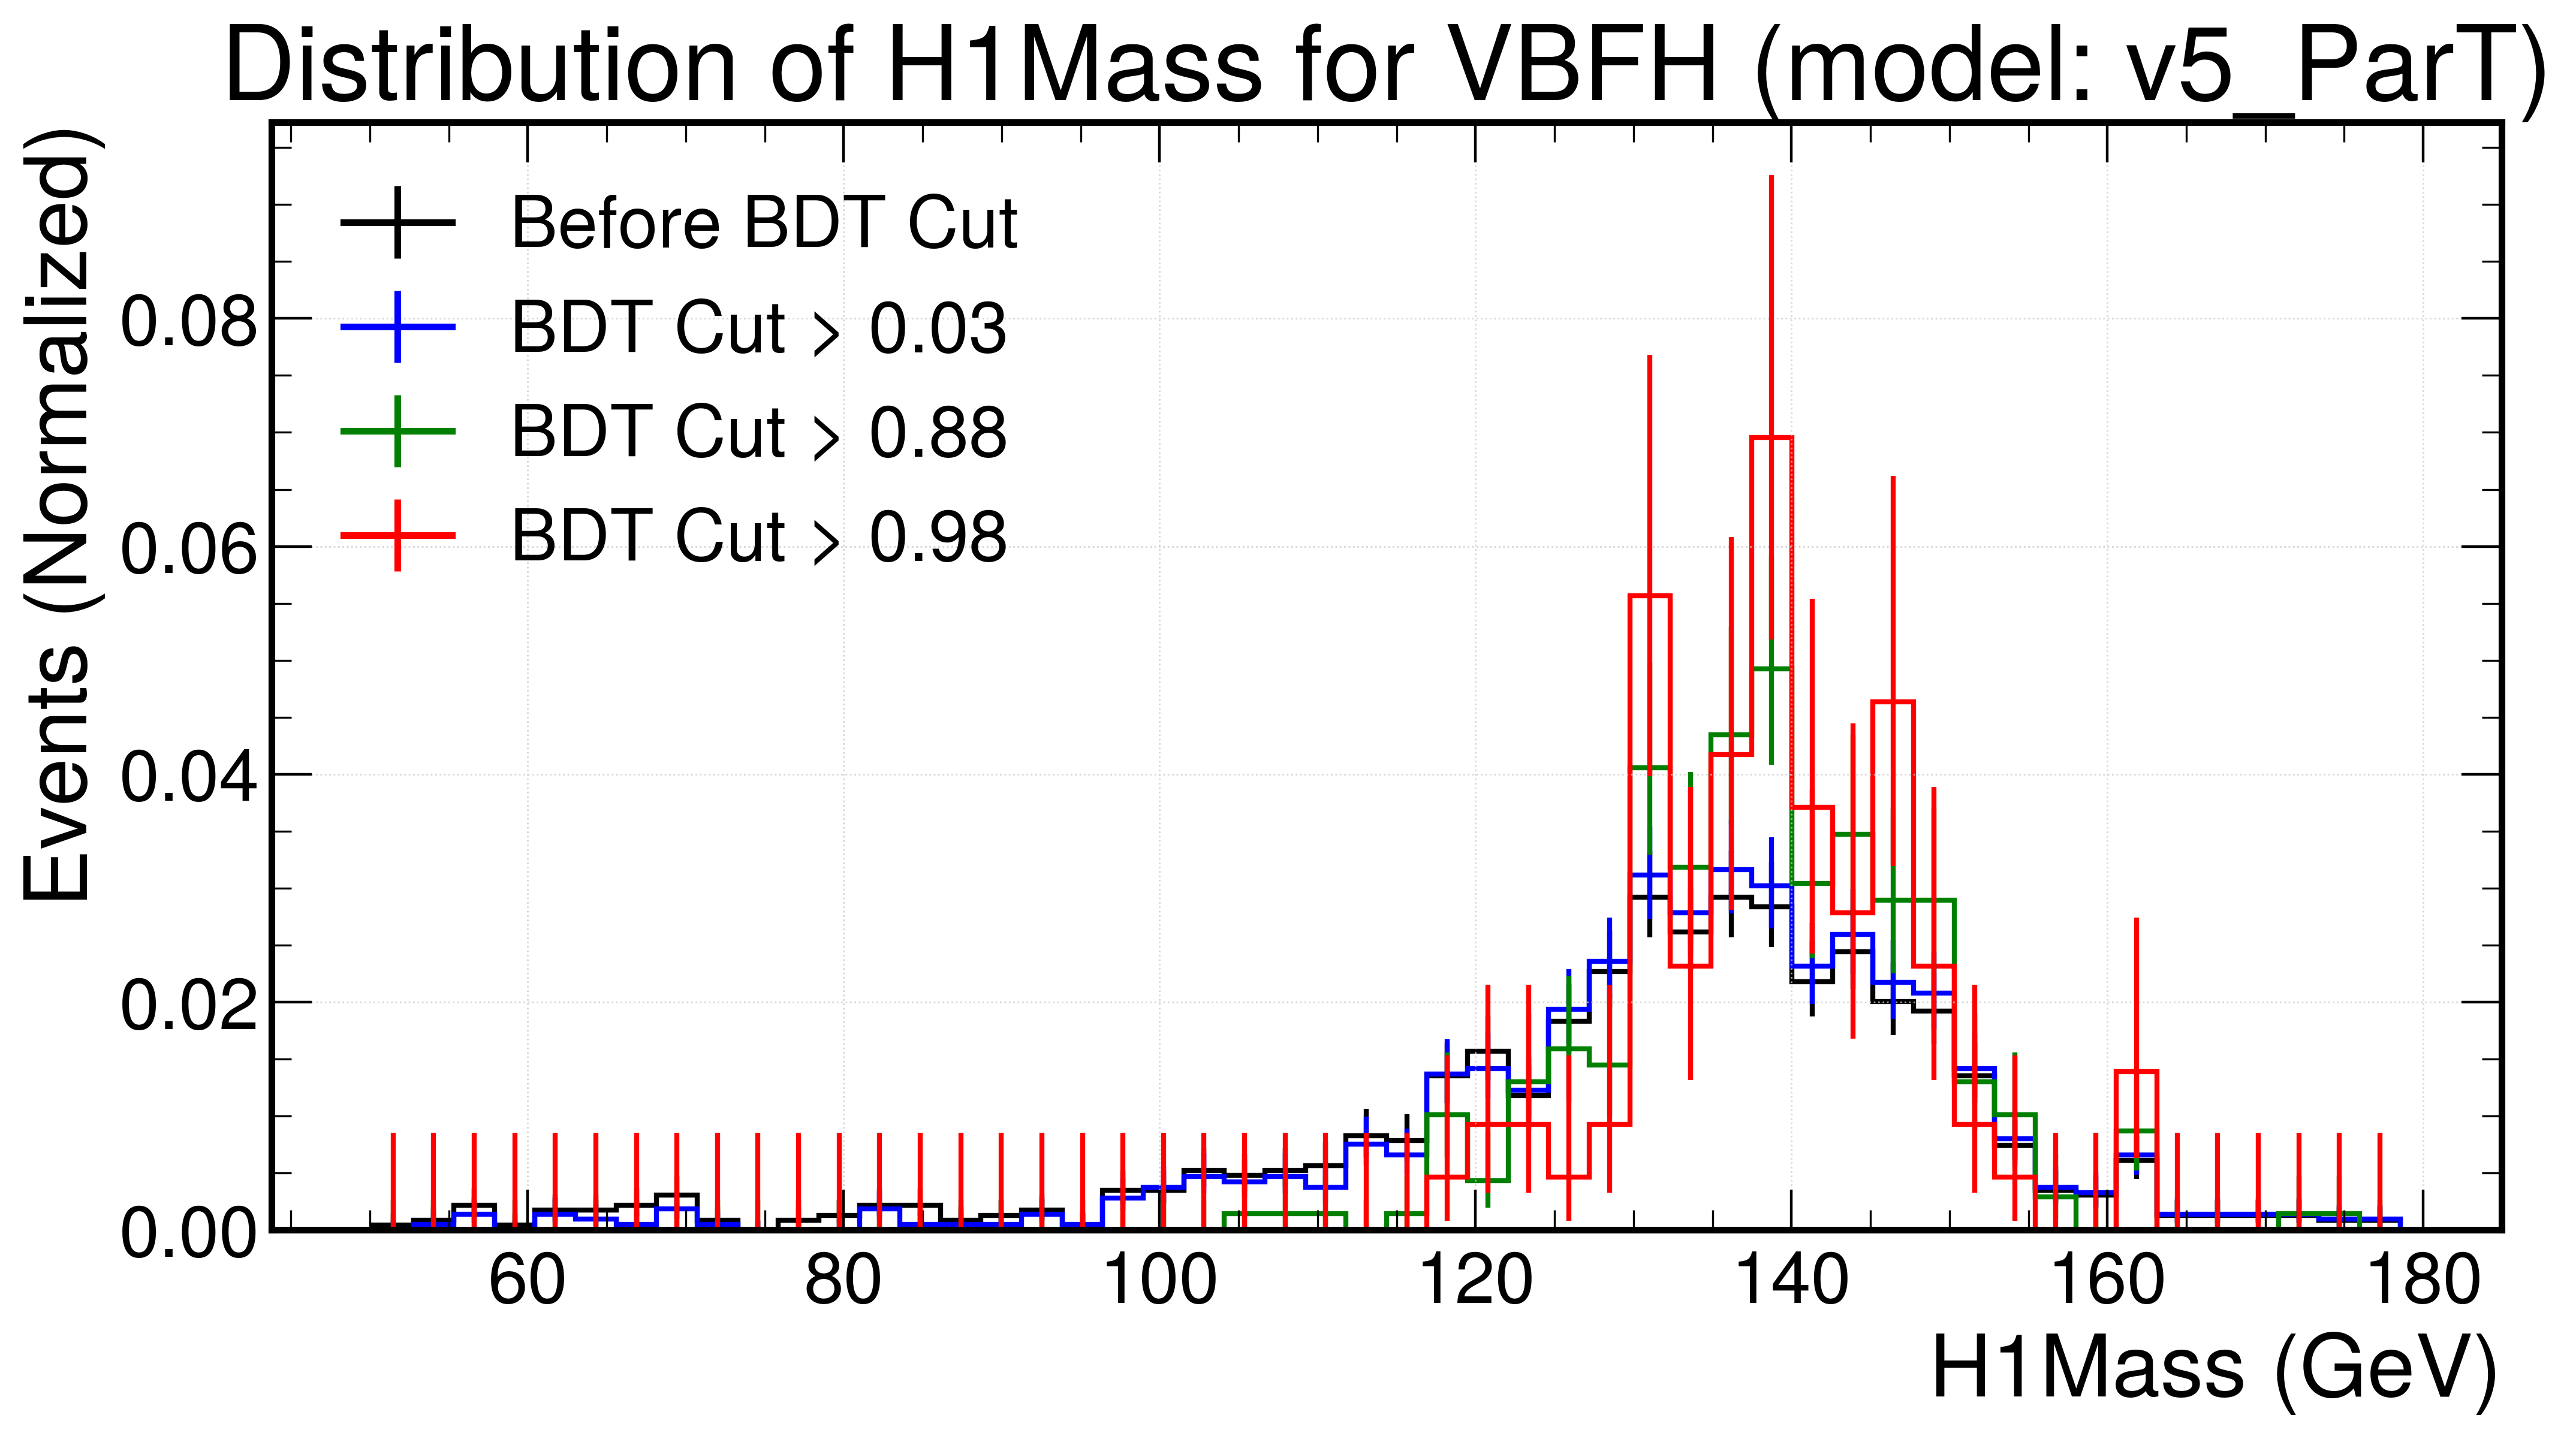

In [14]:
"""

Execute functions here 

"""

path_to_dir = "/home/users/dprimosc/data/24Sep25_v12v2_private_signal"
year = "2022"
jet_collection = "bbFatJet"
jet_index = 0
jet_coll_pnet = "ParTTXbb"  # "PNetTXbbLegacy"
jet_coll_mass = "ParTmassVis"  # "PNetMassLegacy"

bdt_models = {
    # "v5_PNetLegacy": {
    #    "config": "v5",
    #    "model_name": "24May31_lr_0p02_md_8_AK4Away",
    # },
    "v5_ParT": {
        "config": "v5_glopartv2",
        "model_name": "24Sep27_v5_glopartv2",
    },
}
print(bdt_models.items())
model_key = bdt_models.items()

bdt_score_dict, bdt_score_vbf_dict, bdt_df_dict = load_events_and_bdt(
    path_to_dir, year, jet_coll_pnet, jet_coll_mass, bdt_models
)


plot_bdt_features(bdt_score_dict, bdt_score_vbf_dict, bdt_df_dict, "v5_ParT")